# Getting started with Chameleon
## Introduction
This package is designed to perform Bayesian History Matching (BHM) to calibrate a computer model to data. It contains general functions to perform BHM, and specific wrappers to calibrate our lab's model of cardiac growth & remodeling. The goal of this notebook is to provide a tutorial of our BHM software package using a simple example.

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pre-processing
### Generating synthetic data
In this example, we will generate some data from a model, and then try to calibrate the model to the data. We will use a simple second-order polynomial function to generate the data, and then try to calibrate the function to the data. The function is:

In [30]:
import numpy as np

def poly_func(t, x0, x1, x2):
    return x0 + x1*t + x2*t**2

To generate the data, we choose some values for the parameters $x_0 = 2.0$, $x_1 = 4.0$, and $x_2 = -0.3$, and then generate some data points using the function, with random noise added. We "measure" at four time points:

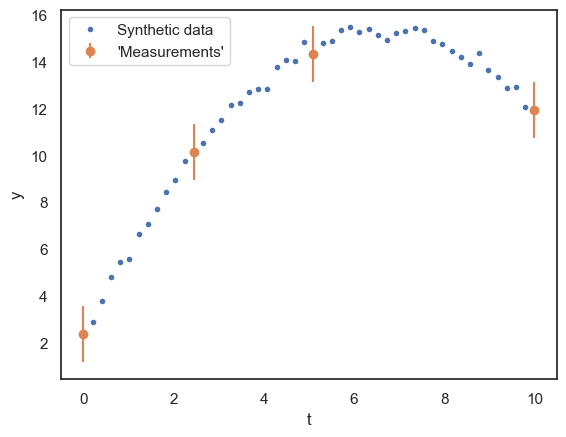

In [31]:
import matplotlib.pyplot as plt

# Generate data
x_target = [2, 4, -0.3]
t = np.linspace(0, 10, 50)

# Generate data
y = poly_func(t, x_target[0], x_target[1], x_target[2])

# Add noise
np.random.seed(0)
y += np.random.normal(0, 0.2, y.shape)

i_sample = [0, int(len(t)/4), int(len(t)/2), -1]
data_mean = y[i_sample]
data_std = np.array([0.1*data_mean[-1]] * 4)
data_names = ['y0', 'y1', 'y2', 'y3']

# Plot function
fig, ax = plt.subplots()
ax.plot(t, y, '.')
ax.errorbar(t[i_sample], data_mean, yerr=data_std, fmt='o')
ax.set(xlabel="t", ylabel="y")
ax.legend(['Synthetic data', "'Measurements'"])
plt.show()

### Preparing data
We first set up a dictionary with the parameters to calibrate. In this case, we have three parameters, $x0$, $x_1$, and $x_2$, and we set the limits of the search space for each parameter. In this test case, we can also set the target values for each parameter, which will only be used during the plotting phase to evaluate if the BHM algorithm can find the correct values. Naturally, in a real-world setting this optional argument should not be used.

In [32]:
pars = {'x0': {'limits': [-10, 10], 'target': x_target[0]},
        'x1': {'limits': [-10, 10], 'target': x_target[1]},
        'x2': {'limits': [-2, 2], 'target': x_target[2]}}

The data is expected in a Pandas dataframe with the mean $\mu$ and standard deviation $\sigma$ for each data point. We will create a dataframe with the data we generated earlier. Note that our BHM framework considers each output as an independent metric, even though in this case the data points are correlated.

In [33]:
import pandas as pd

# Create dataframe with mean and standard deviation of each data point
data = pd.DataFrame(columns=['mu', 'sigma'], index=data_names)
data['mu'] = data_mean
data['sigma'] = data_std
data

,mu,sigma
y0,2.352810,1.195745
y1,10.148876,1.195745
y2,14.308044,1.195745
y3,11.957452,1.195745


## Getting ready to rumble: the Camouflage class
### Initializing a single wave
Bayesian History Matching (BHM) proceeds in 'waves'. During each wave, we run the model for a set of parameter values, and then discard the parameter values that are deemed implausible using Bayes' theorem. We then run another wave using the reduced parameter space and a stricter implausibility threshold. We continue this process until, thus shrinking the parameter space until convergence, ending up with a range of parameter values that match the data within a certain confidence interval. For more information on BHM, see [1] and [2].

All functions to run BHM are contained in the class Camouflage, which needs to be initialized for each wave. A directory (specified through the second argument, `root_dir`) will be created, we will here name it 'demo' and place it in the current notebook directory. This directory will store all the results of the BHM algorithm. The wave class generates a set of parameter values `x_emu` that are used to train the emulator, and a subset of these parameter values `x_sim` that are used to run the model. Built-in log functions will report the progress of the BHM algorithm. 

In [34]:
from chameleon import Camouflage
import pathlib

# Specify export directory
dir_nb = pathlib.Path().absolute()
dir_main = dir_nb / 'demo'

# Initialize wave
wave = Camouflage(0, dir_main, 3, pars, data, nroy=None, n_emu0=2**10, n_emu_min=50, clear_dir=True)


------
Wave 1
------
Generated emulation point cloud with 1024 points


### Initial space-filling design
Initializing the wave resulted in a large set (in this case `n_emu0` = $2^{10}$, default is $2^{20}$) of parameter values `x_emu` being generated. A subset of these parameter values `x_sim` (default `n_sim`= $2^{7}$) are then selected using `diversipy`, ensuring uniform sampling, to run the model for emulator training and validation. We can plot the parameter values generated by the emulator, and the parameter values that were run through the model. Note that `n_emu0` and `n_sim` have to be a power of 2 since we use Sobol sequences to generate and sample the parameter values. Let's plot the initial space of parameter values $x_0$ and $x_1$, and the subset of parameter values that were selected to run through the model:

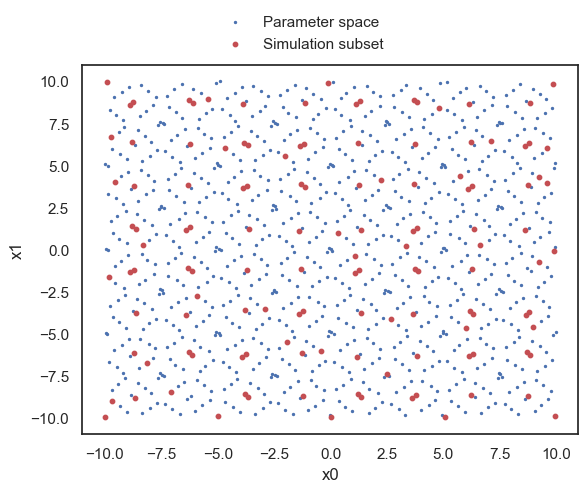

In [35]:
# Plot parameter values
fig, ax = plt.subplots()
plt.scatter(wave.x_emu[:, 0], wave.x_emu[:, 1], s=2)
plt.scatter(wave.x_sim[:, 0], wave.x_sim[:, 1], s=10, c='r')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(['Parameter space', 'Simulation subset'], bbox_to_anchor=(0.25, 1.00), frameon=False)
plt.show()

### Running a single wave
Now that we have set up the Camouflage class, we can start running our first wave. The wave class does not run the model itself (more on how to include more complex models later), so we need to run the model ourselves using the parameters that were selected in this wave as input, and return the simulated data points to the wave class:

In [36]:
# Run model
y = np.zeros((wave.n_sim, len(t)))
for i in range(wave.n_sim):
    y[i, :] = poly_func(t, wave.x_sim[i, 0], wave.x_sim[i, 1], wave.x_sim[i, 2])
    
# Add to waive
wave.y_sim = y[:, i_sample]

We can then plot the simulated data points, note the large spread in the simulated results, well outside of the error bars of the data point we are trying to match.

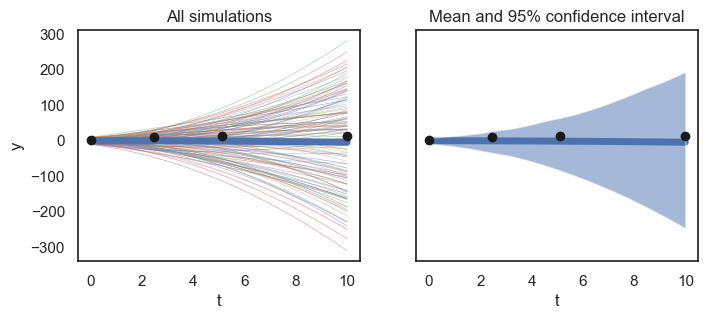

In [37]:
# Plot simulated data
import seaborn as sns

# Create utility function to evaluate the model compared to data
def plot_sims(data_t, data_mean, data_std, t, y):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True, sharex=True)
    
    # All simulations
    ax[0].set_title('All simulations')
    ax[0].plot(t, y.mean(axis=0), linewidth=5, zorder=1)
    ax[0].plot(t, y.T, linewidth=0.5, zorder=0, alpha=0.5)
    ax[0].errorbar(data_t, data_mean, yerr=2*data_std, fmt='o', linewidth=3, color="k")
    ax[0].set(xlabel='t', ylabel='y')
    
    # Mean and 95% confidence interval
    ax[1].set_title('Mean and 95% confidence interval')
    ax[1].plot(t, y.mean(axis=0), linewidth=5, zorder=1)
    ax[1].fill_between(t, np.percentile(y, 2.5, axis=0), np.percentile(y, 95.0, axis=0), alpha=0.5)
    ax[1].errorbar(data_t, data_mean, yerr=2*data_std, fmt='o', linewidth=3, color="k")
    ax[1].set(xlabel='t')
    
    plt.show()

# Plot simulated data
plot_sims(t[i_sample], data_mean, data_std, t, y)

Using the wave class, we will now train Gaussian Process Emulators (GPEs) to emulate the model. 80% of the model results will be used to train the GPEs and the remaining 20% to validate the training quality.

Training GPEs using PyTorch...


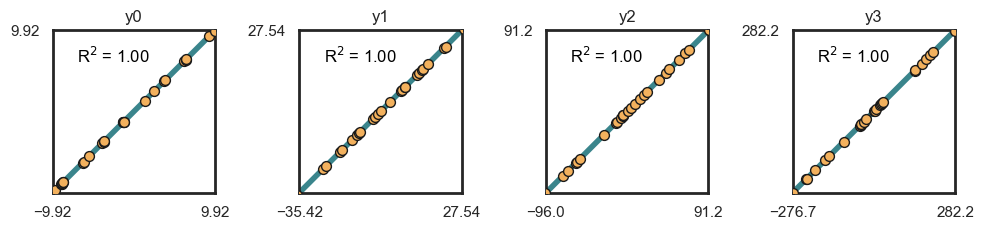

In [38]:
# Train and validate emulators
wave.gpe_training_validation()

wave.plot_r2(show_fig=True)

We will then use the trained GPEs to predict the simulated data points for all parameters in the NROY region. We then use the implausibility criterion to determine which parameter sets remain in the NROY region. In brief, this metric compares the mean of the emulated and observed data, and divides it by the variance of the emulated and observed data. Thus, the lower this score the *less implausible* a point is to be part of the solution space we are looking for. Here, we discard all parameters sets with an implausibility metric lower than a set threshold, in this case a threshold of `wave.threshold`=3, set when we initialized the Camouflage class (third argument). Note from the log messages and the plots how the NROY region gets reduced dramatically, with only ~1% of the original parameter sets remaining, stored in the `nroy` attribute of the wave class. The corresponding emulated outputs are also stored in `nroy_y`, which we here plot to show that they are now closer, but not yet all within the desired data confidence interval. The plots shown below are stored in the wave directory by default to monitor progress.

In [39]:
# Predict data for all parameter values
wave.gpe_emulate()

# Calculate implausibility and find non-implausible parameter values
wave.find_nroy()

wave.plot_nroy(show_fig=True, save_fig=True)

Emulating 1024 points...
Emulation completed in 0.02 seconds
10 points remaining in NROY region (0.98% of original space)
y3 is the most implausible output (52.44% of all points)


## Running a full BHM scheme
As decribed earlier, Bayesian History Matching proceeds in 'waves'. During each wave, we run the model for a set of parameter values, and then discard the parameter values that do not match the data. We then repeat the process with a smaller range of parameter values. We continue this process until we have a small enough range of parameter values that match the data. We then repeat the process with a new set of data points, and continue until we have a set of data points that match the model. We then have a set of parameter values that match the model and the data. We can then use these parameter values to make predictions about the model.

The following code will run a full BHM scheme for our example. Most of the function described in the previous section (training/validation, evaluation of the NROY using GPEs, and selection of the new NROY region) are wrapped for convenience in the `wave.surf` function. When running the next cell, mote from the log messages how the parameter space is reduced with each wave. 

In [40]:
# Specify export directory
dir_main = dir_nb / "demo"

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)

    # Initialize wave    
    wave = Camouflage(i_wave, dir_main, wave_threshold, pars, data, nroy=nroy,
            n_emu0=2**15, n_emu_min=1000, clear_dir=(i_wave == 0), clear_log=(i_wave == 0))

    # Run simulations for all parameter sets in current wave set x
    y = np.zeros((wave.n_sim, len(t)))
    for i in range(wave.n_sim):
        y[i, :] = poly_func(t, wave.x_sim[i, 0], wave.x_sim[i, 1], wave.x_sim[i, 2])
    wave.y_sim = y[:, i_sample]

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    wave.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = wave.is_flooded(i_wave, min_waves=5, max_waves=6)
    nroy = wave.nroy
    i_wave += 1

-----------
Parameters:
-----------
- x0: [-10.0 - 10.0]
- x1: [-10.0 - 10.0]
- x2: [-2.0 - 2.0]


-------------
Observations:
-------------
- y0: 2.3528104691935328 ± 1.1957451943957207
- y1: 10.148875600006491 ± 1.1957451943957207
- y2: 14.308043982947803 ± 1.1957451943957207
- y3: 11.957451943957206 ± 1.1957451943957207


-------------
Constants:
-------------
None specified


------
Wave 1
------
Generated emulation point cloud with 32768 points
Training GPEs using PyTorch...
Emulating 32768 points...
Emulation completed in 0.1 seconds
1549 points remaining in NROY region (4.73% of original space)
y3 is the most implausible output (52.06% of all points)
NROY size change at Wave 1 is -0.95: no convergence

------
Wave 2
------
Training GPEs using PyTorch...
Emulating 1549 points...
Emulation completed in 0.01 seconds
95 points remaining in NROY region (0.29% of original space)
y3 is the most implausible output (77.99% of all points)
NROY size change at Wave 2 is -0.94: no convergenc

## Post-processing: evaluating the results
### Check emulator quality
With our first BHM scheme completed, we can now analyze the results. All output results and some figures are already stored in the directory wave.dir (in this case the subdirectory "demo" from where this notebook is stored on your local system. First, it is important to always check if the emulators were trained correctly.

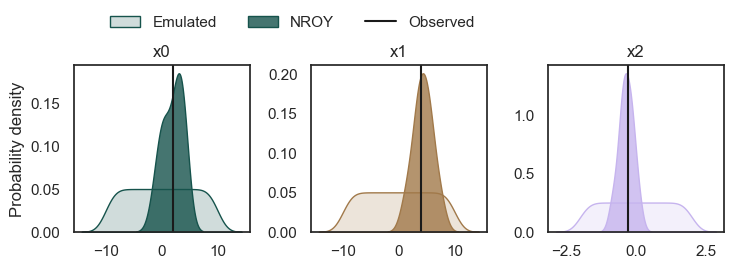

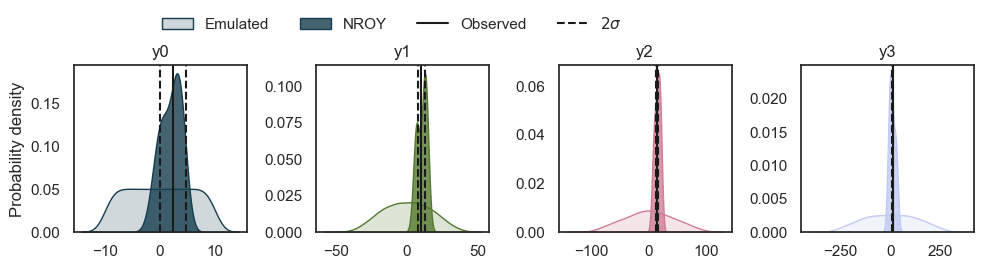

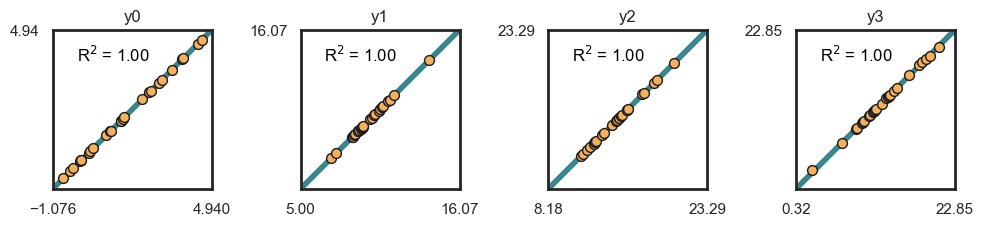

In [41]:
wave.plot_r2(show_fig=True, save_fig=False)

 ### Run posterior simulations
 With the emulator quality confirmed, we can run the model for the parameter values in the final NROY region, and plot the results. Each wave samples `n_posterior` parameters to be used to run your model to obtain the posterior distribution. After running posterior simulations, we store the results in the wave class for additional plotting later. When using these parameters to run the model, note how the simulated data points are now within the error bars of the observed data point.

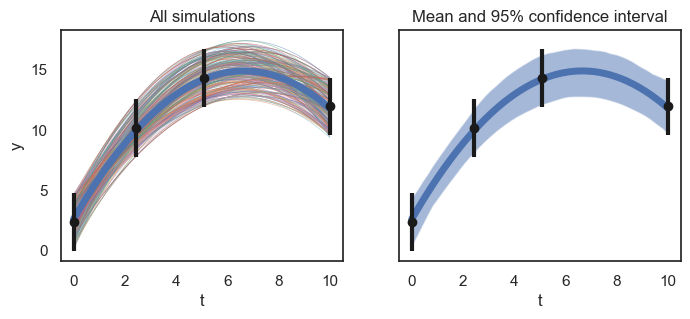

In [42]:
# Run simulations for all parameter sets in final NROY region
y = np.zeros((wave.n_posterior, len(t)))
for i in range(wave.n_posterior):
    y[i, :] = poly_func(t, wave.x_posterior[i, 0], wave.x_posterior[i, 1], wave.x_posterior[i, 2])

# Add to wave
wave.y_posterior = y[:, i_sample]
wave.pickle_wave()
    
plot_sims(t[i_sample], data_mean, data_std, t, y)

### Use TrueColors to analyze the results
This package also includes a class called TrueColors that contains a comprehensive set of plotting functions to analyze the BHM results. We can for example plot the posterior multi-dimensional parameter space to check for any strongly correlated parameters, or parameters that are not influential for the output results (see the Global Sensitivity Analysis section for more useful tools on this). All figures we generate here will by default by saved to a new directory named "results" inside the parent wave directory `dir_main`.

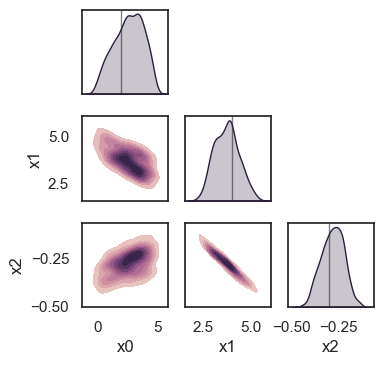

In [43]:
from chameleon import TrueColors

# Initialize camouflage class
camo = TrueColors(dir_main)

# Plot posterior parameter distribution
camo.plot_nroy_x(show_fig=True)

Note how the means of the dsitributions are close to the target values we set earlier, and a strong correlation between $x_1$ and $x_2$. The same plot is available for the output space.

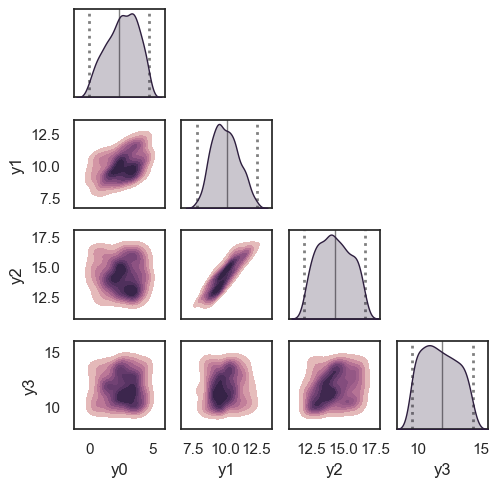

In [44]:
# Plot posterior emulated output distribution
camo.plot_nroy_y(show_fig=True)

Remember how we stored the posterior simulation results? We can use the TrueColors class to plot the posterior distributions of the simulated data points. It will generate a box and violin version, we here show the box plot version.

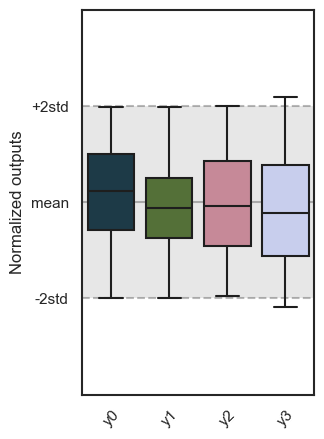

In [45]:
# Plot posterior distributions
camo.plot_nroy_data(show_box=True)

We can also plot the evolution of the NROY over the course of the BHM scheme. Note how the NROY shrinks with each wave. This plot can be time-consuming to generate for large datasets and number of parameters, so it is turned off by default.

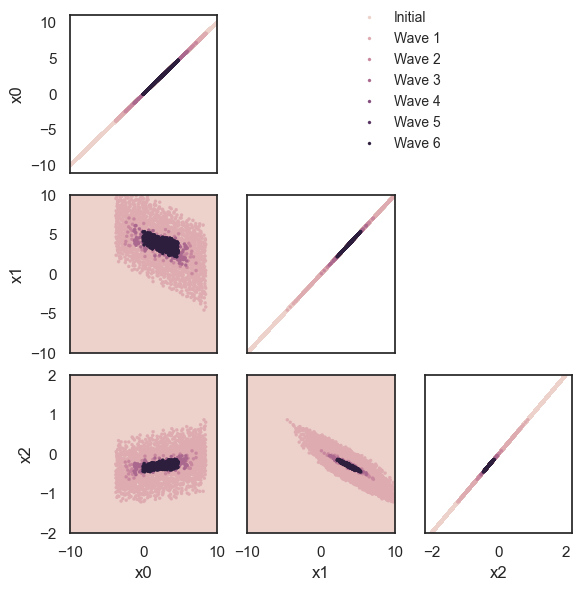

In [48]:
camo.plot_nroy_waves(show_fig=True, tile_size=2)

Now plot the evolution of the NROY for each parameter and output, honestly we just love how cool this plot looks, but it also gives useful information on how each output converges and compares to the data. Specific outputs can be selected using the `y_names` argument, if this argument is not specified it will plot all outputs.

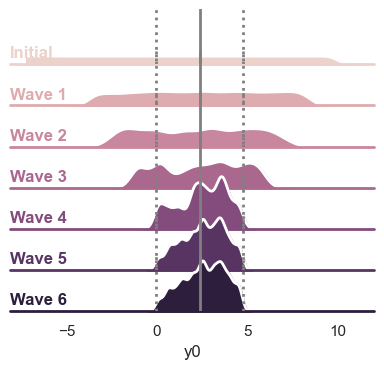

In [49]:
# Plot wave progression
camo.plot_waves_y(show_fig=True, y_names=('y0', ))

The same for individual parameters:

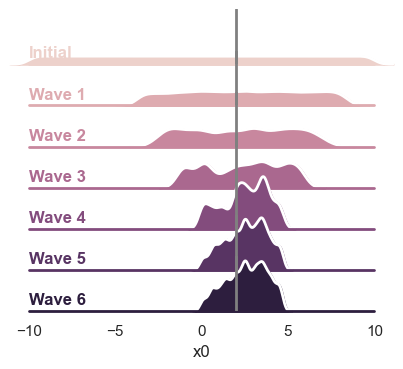

In [50]:
camo.plot_waves_x(show_fig=True, x_names=('x0', ))

## Global sensitivity analysis
Before running BHM (or any model calibration really), it is advisable to perform a sensitivity analysis to identify which parameters need to be calibrated and which can be set as constant. This package include a Sobol global sensitivity analysis using the SALib package. In most models, performing a global sensitivity analysis is computationally expensive, so here we take advantage of the low computational cost of the emulators to perform the analysis. The following code is an example of how to run the analysis. Similar to a BHM wave, we need to run our own model with the parameter sets given by the Saltelli method. The sensitivity analysis will be performed on the initial parameter space.

In [51]:
dir_sense = dir_nb / 'demo' / 'sensitivity'

# Setting up the wave class
wave = Camouflage(0, dir_sense, 5.0, pars, data, nroy=nroy,
            clear_log=True, n_emu0=2**11, n_emu_min=2**11)

# Run simulations for all parameter sets in current wave set x
y = np.zeros((wave.n_sim, len(t)))
for i in range(wave.n_sim):
    y[i, :] = poly_func(t, wave.x_sim[i, 0], wave.x_sim[i, 1], wave.x_sim[i, 2])
wave.y_sim = y[:, i_sample]

# Wrapper to run gpe_training_validation and sobol_sensitivity
wave.surf_sensitivity()

-----------
Parameters:
-----------
- x0: [-10.0 - 10.0]
- x1: [-10.0 - 10.0]
- x2: [-2.0 - 2.0]


-------------
Observations:
-------------
- y0: 2.3528104691935328 ± 1.1957451943957207
- y1: 10.148875600006491 ± 1.1957451943957207
- y2: 14.308043982947803 ± 1.1957451943957207
- y3: 11.957451943957206 ± 1.1957451943957207


-------------
Constants:
-------------
None specified


------
Wave 1
------
Regenerating emulation cloud from 611 to 2048 points...
Training GPEs using PyTorch...
Performing sensitivity analysis...
Emulating 2048 points...
Emulation completed in 0.9 seconds


/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


The results of the sensitivity analysis are stored in the Camouflage class and are pickled to wave.dir. We can plot the results using the Camouflage class. First, we can plot the importance of each parameter on each output, in circle or matrix format, and the total importance of each parameter on the entire parameter space.

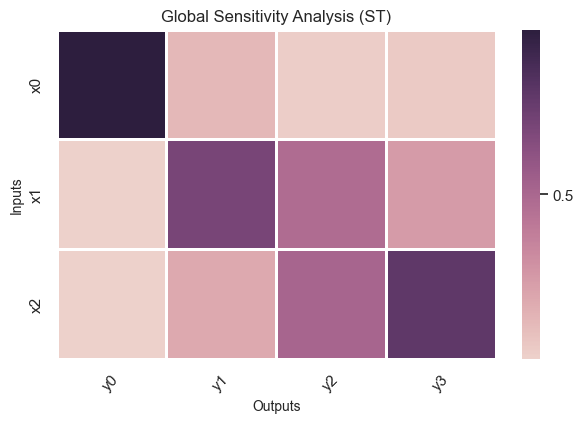

In [52]:
# Run sensitivity analysis
camo = TrueColors(dir_sense)

camo.plot_sensitivity_matrix(show_fig=True, tile_size=2)

As expected from the way we set up our polynomial function to generate the 'data', the higher the order of the polynomial coefficients $x_i$, the more infuential they are to the $y$ values that were 'measured' later. It can also be useful to see the total importance of each parameter on the entire parameter space. This plot is not very interesting for this simple analysis, but can be useful for more complex models:

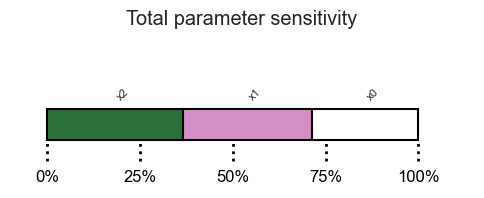

In [57]:
camo.plot_sensitivity_total(show_bar=True)

 Finally, we can also visualize this analysis using a connectivity plot, which looks really cool but is a little less straightforward to interpret than the matrix format above. Again, this plot is not very interesting for this simple analysis, but can be useful for more complex models:

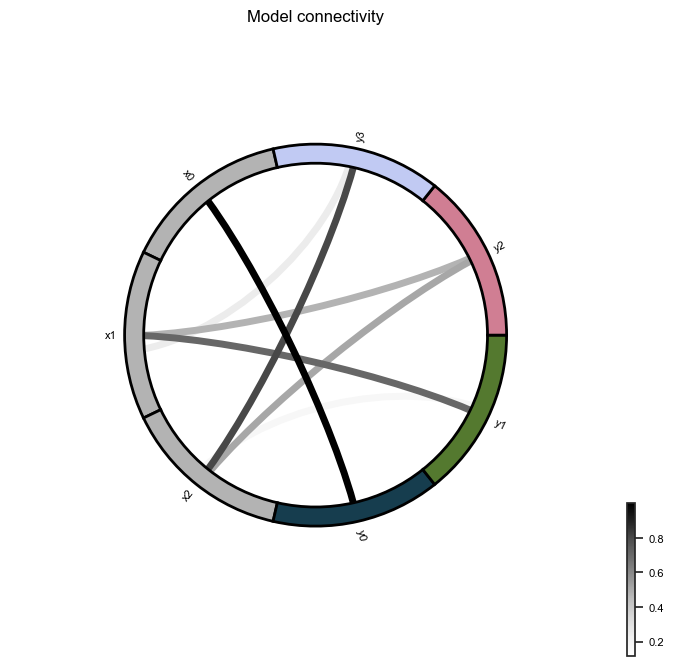

In [59]:
camo.plot_connectivity(show_fig=True)

## References
[1] Jones, C. E. & Oomen, P. J. A. Synergistic Biophysics and Machine Learning Modeling to Rapidly Predict Cardiac Growth Probability. bioRxiv 2024.07.17.603959 (2024) doi:10.1101/2024.07.17.603959.
[2] Andrianakis, I. et al. Bayesian History Matching of Complex Infectious Disease Models Using Emulation: A Tutorial and a Case Study on HIV in Uganda. Plos Comput Biol 11, e1003968 (2015).
  